In [1]:
from IPython.display import HTML
HTML('''
<style>
    body {
        font-family: "HelveticaNeue", sans-serif; /* Elegant, simple sans-serif font */
        color: #333; /* Dark gray for readability */
        background-color: #f8f8f8; /* Light gray background for minimal eye strain */
    }
    h1, h2, h3, h4 {
        color: #2a2a2a; /* Dark text for contrast */
        padding: 0.4em 0.6em; /* Padding for a better visual grouping */
        margin-top: 0.5em; /* Space above headings */
        margin-bottom: 0.5em; /* Space below headings */
    }
    h1 {
        background: linear-gradient(to right, #6a11cb, #2575fc); /* Gradient from purple to blue */
        font-size: 24px; /* Larger font size for main titles */
        color: white; /* White text for better contrast on dark backgrounds */
        border-radius: 8px; /* Rounded corners */
        box-shadow: 0 2px 5px rgba(0,0,0,0.2); /* Subtle shadow for depth */
    }
    h2 {
        background: linear-gradient(to right, #fc4a1a, #f7b733); /* Gradient from red to yellow */
        font-size: 20px; /* Smaller than h1 */
        color: white; /* White text */
        border-radius: 6px; /* Slightly less rounded corners than h1 */
    }
    h3 {
        font-size: 18px; /* Smaller than h2 */
        background: linear-gradient(to right, #0077b6, #06d6a0); /* Vibrant blue to lighter blue gradient */
        color: #ffffff; /* White text for better contrast */
        border-radius: 4px; /* Maintain rounded corners */
    }
    h4 {
        background: linear-gradient(to right, #b5179e, #ffba08); /* Pink to lighter pink gradient */
        color: #ffffff; /* White text for readability */
        border-radius: 4px; /* Consistent rounded corners */
        text-align: left; /* Centered text, as previously styled */
        font-style: italic; /* Maintain italic style */
    }
    .text_cell_render p {
        font-size: 14px; /* Regular text size */
    }
</style>
''')


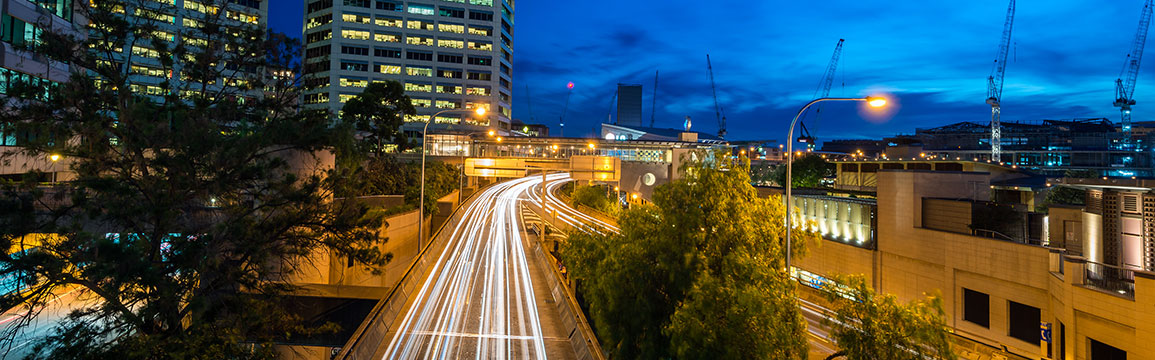

# Greater Sydney Analysis 
**Marc Caramoan**: *510435765*
**Tyler Sitchon**: *510433392*

## Task 1 - Importing and Reading Data
The files we have to work with include:
- The SA2 regions found in the `SA2_2021_AUST_SHP_GDA2020` folder
  - We can filter this down to the Greater Sydney areas
- Businesses through the `Businesses.csv` file
  - Includes # of business by industry and SA2 region
- Stops through the `Stops.txt` file
  - Includes locations of all PT stops including trains and buses in GTFS format
- Polls through the `PollingPlaces2019.csv` file
  - Includes locations and other details of the polling places
- Schools through the `catchments` directory
  - includes shape files for primary, secondary, and future government schools (`catchments_primary.shp`, `catchments_secondary.shp` & `catchments_future.shp`)
- Population information per SA2 by age range through the `Population.csv` file
- Income via total earnings statistics through the `Income.csv` file

## General Imports

In [258]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

### Business.csv

In [259]:
business_df = pd.read_csv("Businesses.csv")
business_df.head(100)

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
95,A,"Agriculture, Forestry and Fishing",105011094,Coonamble,60,73,177,36,9,4,359
96,A,"Agriculture, Forestry and Fishing",105011095,Nyngan - Warren,78,109,204,39,11,7,448
97,A,"Agriculture, Forestry and Fishing",105011096,Walgett - Lightning Ridge,47,64,151,45,22,8,337
98,A,"Agriculture, Forestry and Fishing",105021097,Broken Hill,36,30,69,7,0,3,143


There are a number of different industries and of course these exist in multiple different SA2 regions. So we should begin by cleaning out (or just selecting the data we want). Below are the different types of `industry_names` of businesses. We should take careful thought into which ones we want to choose.

After some consideration, we should look into "Retail Trade" as this industry is directly connected to consumer activity and is often a strong indicator of foot traffic and economic activity within a community.

In [260]:
unique_industry_names = business_df['industry_name'].unique()
for name in unique_industry_names:
    print(name)

Agriculture, Forestry and Fishing
Mining
Manufacturing
Electricity, Gas, Water and Waste Services
Construction
Wholesale Trade
Retail Trade
Accommodation and Food Services
Transport, Postal and Warehousing
Information Media and Telecommunications
Financial and Insurance Services
Rental, Hiring and Real Estate Services
Professional, Scientific and Technical Services
Administrative and Support Services
Public Administration and Safety
Education and Training
Health Care and Social Assistance
Arts and Recreation Services
Other Services


According to the ABS, the "0_to_50k_businesses" etc columns refer to annual turnover. How do we consider the number of smaller businesses compared to the number of larger businesses when it comes to how "bustling" an SA2 region is?

To calculate the `z-score` for $z_{business}$, which is defined as "businesses per 1000 people" in each SA2 region, we have to determine the ratio of businesses per 1000 people for each SA2, and then standardise those ratios using the z-score formula. More on this later

**Data Cleaning**

Now it would be wise to go through data cleaning. 

We will:
1. Look at the data types of each column
2. Ensure that columns are the correct data type and convert if needed
3. Determine which columns we don't want
4. Identify and remove duplicates
5. Identify null columns

In [261]:
business_df.dtypes

industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

This looks about right

We will drop the `industry_code` as it is redundant, but it is up for debate whether or not we keep the turnover range columns. If our analysis is solely focused on z-score based on the total number of businesses, then we can safely drop the turnover range columns. This makes it easier and simplifies our data. However, we may plan to weigh businesses differently based on their turnover. It makes sense that a city with 1000 small businesses may be less "bustling" than a city with 1000 large businesses, considering more people may go into work at those large businesses, and it is indicative of a business district.

I will just drop the column in-place instead of making a new table.

In [262]:
business_df.drop(['industry_code'], axis=1)

,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...
12212,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


Now we'll look for any duplicates (there shouldn't be any duplicates):

In [263]:
business_df.duplicated().sum()

0

No we will check for any duplicate values (there shouldn't be any na values):

In [264]:
business_df.isna().sum()

industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64

Looks good, our `business_df` dataframe is ready to be converted into SQL for processing into our SQL database.

### Stops.txt

In [265]:
stops_df = pd.read_csv("Stops.txt")
stops_df.head(-100)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN
...,...,...,...,...,...,...,...,...,...
114613,G288093,NaN,Ryan St At Creedon St,-31.975072,141.440711,1.0,NaN,0,NaN
114614,G288094,NaN,Creedon St Opp Pell St,-31.968640,141.435090,1.0,NaN,0,NaN
114615,G288095,NaN,Thomas St At Bromide St,-31.949782,141.453020,1.0,NaN,0,NaN
114616,G288096,NaN,Brookfield Av At Morgan St,-31.956443,141.438225,1.0,NaN,0,NaN


According to the specs this file contains the locations of all the public transport stops **(trains and bus)**, in GTFS format. I couldn't really find any other substantial information on the Transport for NSW website. Based on the specs, we should look at the "number of public transport stops".

In [266]:
stops_df.dtypes

stop_id                 object
stop_code              float64
stop_name               object
stop_lat               float64
stop_lon               float64
location_type          float64
parent_station          object
wheelchair_boarding      int64
platform_code           object
dtype: object

It looks like each stop has a unique `stop_id`, which we can use to count the total number of stops in a particular region. Moreover, it looks like we are given the `stop_lat` and `stop_lon` which we can turn into a `POINT` object for spatial joining.

After some analysis of the other columns, `stop_code`, `parent_station`, `wheelchair_boarding`, `platform_code` seem redundant to our analysis. Because I am dropping a lot of columns, I will just make a separate DF which only copies over the relevant data.

In [267]:
new_stops_df = stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'location_type']].copy()
new_stops_df.head(100)

,stop_id,stop_name,stop_lat,stop_lon,location_type
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN
2,200060,Central Station,-33.884084,151.206292,1.0
3,201510,Redfern Station,-33.891690,151.198866,1.0
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN
...,...,...,...,...,...
95,2170570,"Liverpool Station, Stand C",-33.923738,150.927868,NaN
96,2170801,Remembrance Av Opp Warwick Farm Station,-33.913309,150.934749,NaN
97,219226,Bridge Rd Opp Canterbury League Club,-33.917674,151.087929,NaN
98,219227,"Canterbury League Club, Bridge Rd",-33.917824,151.087741,NaN


Now, very similarly to businesses, check for duplicates or NaN values in important columns. For `location_type`, I am assuming that 1 or NaN is similar to some boolean determinant.

In [268]:
new_stops_df.duplicated().sum()

0

In [269]:
new_stops_df.isna().sum()

stop_id              0
stop_name            0
stop_lat             0
stop_lon             0
location_type    60727
dtype: int64

Last thing to do is to align our stops df to ensure it can easily be analysed spatially. We will use `geopandas` to properly store a geographical point.
The ABS uses an SRID of 4283 so we will make sure this is consistent across our whole data range.

In [270]:
new_stops_df['geom'] = gpd.points_from_xy(new_stops_df.stop_lon, new_stops_df.stop_lat)
new_stops_df = new_stops_df.drop(columns=['stop_lat', 'stop_lon'])
new_stops_df

,stop_id,stop_name,location_type,geom
0,200039,"Central Station, Eddy Av, Stand A",NaN,POINT (151.20666 -33.88221)
1,200054,"Central Station, Eddy Av, Stand D",NaN,POINT (151.20699 -33.88204)
2,200060,Central Station,1.0,POINT (151.20629 -33.88408)
3,201510,Redfern Station,1.0,POINT (151.19887 -33.89169)
4,201646,"Redfern Station, Gibbons St, Stand B",NaN,POINT (151.19888 -33.89333)
...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",NaN,POINT (151.07880 -33.82202)
114714,2137185,"Cabarita Wharf, Side A",NaN,POINT (151.11693 -33.84067)
114715,2137186,"Cabarita Wharf, Side B",NaN,POINT (151.11690 -33.84077)
114716,21501,Parramatta Wharf,NaN,POINT (151.01058 -33.81390)


Then, we should make sure that we specify the **Spatial Reference Identifier (SRID)**, which is 4283, to represent the [Geodetric coordinate system for Australia](https://epsg.io/4283). We will need to convert the 'geom' column of the stops dataframe.

In [271]:
srid = 4283
new_stops_df['geom'] = new_stops_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
new_stops_df

,stop_id,stop_name,location_type,geom
0,200039,"Central Station, Eddy Av, Stand A",NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,Central Station,1.0,POINT (151.206292455081 -33.8840842535493)
3,201510,Redfern Station,1.0,POINT (151.198866071817 -33.8916900512711)
4,201646,"Redfern Station, Gibbons St, Stand B",NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",NaN,POINT (151.07879697831 -33.8220164586429)
114714,2137185,"Cabarita Wharf, Side A",NaN,POINT (151.116926480557 -33.8406690716775)
114715,2137186,"Cabarita Wharf, Side B",NaN,POINT (151.116898892402 -33.8407691073139)
114716,21501,Parramatta Wharf,NaN,POINT (151.010576673346 -33.8139042429414)


Now our stops dataframe is ready to be inserted into our SQL database.

### PollingPlaces2019.csv

In [272]:
polls_df = pd.read_csv("PollingPlaces2019.csv")
polls_df.head(100)

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,2664,1,Hurstville East (Barton),Hurstville Public School,72 Forest Rd,NaN,NaN,HURSTVILLE,NSW,2220.0,-33.96410,151.11100,POINT (-33.9641 151.111)
96,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,2665,1,Hurstville North,Kingsway Scout Hall,74 Barnards Ave,NaN,NaN,HURSTVILLE,NSW,2220.0,-33.95440,151.09600,POINT (-33.9544 151.096)
97,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,2666,1,Kingsgrove,South-West Evangelical Church Hall,4 Morgan St,NaN,NaN,KINGSGROVE,NSW,2208.0,-33.94010,151.10300,POINT (-33.9401 151.103)
98,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,79715,1,Kingsgrove North (Barton),Kingsgrove North High School,2 St Albans Rd,NaN,NaN,KINGSGROVE,NSW,2208.0,-33.93385,151.09621,POINT (-33.93385 151.09621)


The `polls_df` simply holds the details of a federal election polling location, including its unique id through `polling_place_id`, it has a `state` and a `division_name`. Some have addresses and suburbs, but there are a large number of null values in these too. Some don't have latitude and longitude values either. They already come with geometric point objects which use SRID 4283 as well, as per [AEC](https://data.aurin.org.au/dataset/au-govt-aec-aec-federal-election-polling-places-2019-na). We'll first just take a general look at all columns.

In [273]:
polls_df.dtypes

FID                             object
state                           object
division_id                      int64
division_name                   object
polling_place_id                 int64
polling_place_type_id            int64
polling_place_name              object
premises_name                   object
premises_address_1              object
premises_address_2              object
premises_address_3              object
premises_suburb                 object
premises_state_abbreviation     object
premises_post_code             float64
latitude                       float64
longitude                      float64
the_geom                        object
dtype: object

Moreover, it looks like all of the data is already cleaned to hold NSW locations only.

In [274]:
unique_states = polls_df['state'].unique()
for state in unique_states:
    print(state)

NSW


We'll check for duplicates now, but it seems that there is a lot of NaN values for some reason.

In [275]:
polls_df.isna().sum()

FID                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1              193
premises_address_2             2816
premises_address_3             2895
premises_suburb                 115
premises_state_abbreviation       0
premises_post_code              109
latitude                        140
longitude                       140
the_geom                        140
dtype: int64

Immediately, I already want to drop a lot of columns which are redundant or hold a lot of NA values, or won't really help us with our analysis. It is important to know that in terms of our "bustling" metric, we only need to look at **"federal election polling locations"**, which I assume is the number of polling locations per region. I will get rid of:
- `state`
  - because we already know they are all NSW
- `premises_state_abbreviation`
  - same as `state`
- `premises_address` `1`, `2` and `3`
  - because they only provide street location, and we don't need it
- `latitude` and `longitude` after converting into a geographical point.

In terms of working with polling locations that have `NaN` for `latitude` and `longitude` or `the_geom`, we can still use `division_name` or `premises_suburb`, or even `premises_post_code` to extract as much location data as we can, so we'll keep those in for now.

I want to see if we can get rid of the lengthy `FID` column by making sure that `polling_place_id` is actually unique. There are 2930 total rows so we should have 2930 total unique IDs.

In [276]:
len(polls_df['polling_place_id'].unique()) == 2930

True

Because there are different `polling_place_id` values for each record, I feel confident in removing the lengthy `FID`. Now just checking to see how many of those "Special Hospital Team" polling locations have no geometric location. It matters because I am not entirely sure how it may impact the geometric applications.

In [277]:
filtered_polls = polls_df[polls_df['polling_place_type_id'] == 2]
filtered_polls[['polling_place_id', 'polling_place_type_id', 'polling_place_name', 'the_geom']].isna().sum()

polling_place_id           0
polling_place_type_id      0
polling_place_name         0
the_geom                 122
dtype: int64

Now I will make my own geographical point objects from the longitude and latitude:

In [278]:
polls_df['geom'] = gpd.points_from_xy(polls_df.longitude, polls_df.latitude)  # creating the geometry column
polls_df

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858),POINT (150.85800 -34.56420)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546),POINT (150.85975 -34.55082)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424),POINT (150.42400 -34.44090)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866),POINT (150.86600 -34.53160)


Now we should specify the SRID for our `the_geom` column and ensure we convert it to WKT format.

In [280]:
srid = 4283
polls_df['geom'] = polls_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polls_df

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858),POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546),POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424),POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866),POINT (150.866 -34.5316)


Now everything looks good to drop redundant columns!

In [281]:
polls_df = polls_df.drop(columns=['state', 'premises_state_abbreviation', 
                                  'premises_address_1', 'premises_address_2', 
                                  'premises_address_3', 'FID', 
                                  'latitude', 'longitude', 'the_geom'])
polls_df

,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_post_code,geom
0,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,POINT EMPTY
1,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,POINT EMPTY
2,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,POINT EMPTY
3,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,ORANGE,2800.0,POINT EMPTY
4,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...
2925,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,2528.0,POINT (150.858 -34.5642)
2926,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,2528.0,POINT (150.8597546 -34.5508228)
2927,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,2575.0,POINT (150.424 -34.4409)
2928,150,Whitlam,564,1,Windang,Windang Public School,WINDANG,2528.0,POINT (150.866 -34.5316)


Now our `polls_df` dataframe is ready for insertion into our SQL database.

### Population.csv

In [39]:
population_df = pd.read_csv("Population.csv")
population_df.head(100)

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,117031643,Rosebery - Beaconsfield,772,372,271,361,1272,2063,2100,1457,...,600,551,439,375,279,245,174,126,108,12408
96,117031644,Sydney (North) - Millers Point,214,137,109,174,672,1216,1102,884,...,517,466,475,402,368,344,253,146,105,8199
97,117031645,Sydney (South) - Haymarket,499,300,222,500,2920,4586,4031,2538,...,810,599,560,427,353,256,147,95,74,20346
98,117031646,Ultimo,228,167,92,299,1312,1509,1205,785,...,335,274,223,169,174,120,66,56,50,7558


In regards to the `population_df` dataframe, we need mostly all the data for our bustling metric calculations later on. The only type of cleaning we will have to do is duplicate and NaN values. But we will mainly be looking at the `total_people` column in regards to our $z-scores$.

In [282]:
population_df.dtypes

sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

Checking for duplicate and NaN values...

In [283]:
population_df.duplicated().sum()

0

In [284]:
population_df.isna().sum()

sa2_code              0
sa2_name              0
0-4_people            0
5-9_people            0
10-14_people          0
15-19_people          0
20-24_people          0
25-29_people          0
30-34_people          0
35-39_people          0
40-44_people          0
45-49_people          0
50-54_people          0
55-59_people          0
60-64_people          0
65-69_people          0
70-74_people          0
75-79_people          0
80-84_people          0
85-and-over_people    0
total_people          0
dtype: int64

We'll keep this table as is, and we can use the age ranges for some other complex analysis later on.
Now our `population_df` dataframe is ready for insertion in our SQL database.

### Income.csv

In [40]:
income_df = pd.read_csv("Income.csv")
income_df.head(100)

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
95,105011094,Coonamble,1950,45,48600,62372
96,105011095,Nyngan - Warren,2752,46,50760,57316
97,105011096,Walgett - Lightning Ridge,2627,45,45923,50681
98,105021097,Broken Hill,8459,44,56376,63987


It is important to note that this `income_df` is mainly going to be used for **Task 3**, where we must determine if there is a correlation between a regions bustling score and the median income of each region. So we will keep it as is. Just going to make sure there are no duplicate or NaN values as usual.

In [285]:
income_df.duplicated().sum()

0

In [286]:
income_df.isna().sum()

sa2_code21       0
sa2_name         0
earners          0
median_age       0
median_income    0
mean_income      0
dtype: int64

We'll keep this table as is, and we can use the `earners` and other statistical information for some other complex analysis later on.
Now our `income_df` dataframe is ready for insertion in our SQL database.

### catchments

Each catchment refers to the area around the school in which a resident must reside in order to be accepted.

The [NSW Department of Education](https://data.cese.nsw.gov.au/data/dataset/school-intake-zones-catchment-areas-for-nsw-government-schools) says that these are defined local enrolment areas - every public school reserves enough places within their school for students in their local enrolment area.

In regards to the task at hand, we want to see the **school catchment areas per 1000 young people**. So it looks like all we need is the type of school, its ID, and its `geom` object.

#### primary schools

In [307]:
prim_schools = gpd.read_file("catchments/catchments_primary.shp")
prim_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
1658,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
1659,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
1660,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


Let's first explore the different columns of the datasets:

In [308]:
prim_schools.dtypes

USE_ID          object
CATCH_TYPE      object
USE_DESC        object
ADD_DATE        object
KINDERGART      object
YEAR1           object
YEAR2           object
YEAR3           object
YEAR4           object
YEAR5           object
YEAR6           object
YEAR7           object
YEAR8           object
YEAR9           object
YEAR10          object
YEAR11          object
YEAR12          object
PRIORITY        object
geometry      geometry
dtype: object

It looks like the Years columns are just booleans to see if these schools support a certain year. Because they are already sorted into primary and secondary, we can drop all of these columns for now. I want to see if we can also drop `ADD_DATE`, as well as `PRIORITY`, so we will take a look into `PRIORITY`.

In [309]:
for prio in prim_schools['PRIORITY'].unique():
    print(prio)

None
N


It doesn't look very helpful at all, so we'll probably drop it. We'll also look into converting our geometry objects into a `MULTIPOLYGON`, and conducting a WKT conversion specifying the SRID as well.

In [310]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283

prim_schools_og = prim_schools.copy()  # creating a copy of the original for later
prim_schools['geom'] = prim_schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
prim_schools = prim_schools.drop(columns="geometry")  # deleting the old copy
prim_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((147.9462089946497 -34.55863148...
1658,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((148.12885348977485 -35.6008184...
1659,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((146.86147943204122 -35.8751106...
1660,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((145.18402754685187 -29.6580498...


Now it looks like there's only one type of school here, but if we look into all the unique values, we get primary, infants and central primary. This may be important so we won't drop this column. 

In [311]:
print(prim_schools['CATCH_TYPE'].unique())

['PRIMARY' 'INFANTS' 'CENTRAL_PRIMARY']


We'll go ahead with dropping the Grade Capacity columns, from Kindergarten to Year 12. We'll also drop the Priority column.

In [312]:
prim_schools = prim_schools.drop(columns=['KINDERGART', 'YEAR1', 'YEAR2',
                                          'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6',
                                          'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10',
                                          'YEAR11', 'YEAR12', 'PRIORITY'])
prim_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geom
0,2838,PRIMARY,Parklea PS,20181210,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,MULTIPOLYGON (((147.9462089946497 -34.55863148...
1658,3275,PRIMARY,Tumbarumba PS,20200507,MULTIPOLYGON (((148.12885348977485 -35.6008184...
1659,2239,PRIMARY,Jindera PS,20200507,MULTIPOLYGON (((146.86147943204122 -35.8751106...
1660,3594,PRIMARY,Louth PS,20200604,MULTIPOLYGON (((145.18402754685187 -29.6580498...


Now our `prim_schools` dataframe is ready for insertion in our SQL database.

#### secondary schools

Very similarly to the `prim_schools` dataframe, we'll conduct some basic analysis on secondary schools, primarily:
- What are the different `CATCH_TYPE` values
- What are the different `PRIORITY` values
- Any duplicate or NaN values in important columns
- Convert all polygons to multipolygons for ease of access

In [313]:
second_schools = gpd.read_file("catchments/catchments_secondary.shp")
second_schools.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [314]:
print(second_schools['CATCH_TYPE'].unique())

['HIGH_COED' 'CENTRAL_HIGH' 'HIGH_GIRLS' 'HIGH_BOYS']


It looks like there are 4 types of schools here.

In [315]:
print(second_schools['PRIORITY'].unique())

[None 'Y' 'N']


Honestly no clue what priority means and I couldn't find anything straightforward on the source website either. I will convert the geom columns now. Note this relies on functions that have been run in the primary schools section.

In [322]:
second_schools_og = second_schools.copy()  # creating a copy of the original for later
second_schools['geom'] = second_schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
second_schools = second_schools.drop(columns="geometry")  # deleting the old copy
second_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.81447829547324 -35.7834062...
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.68599834118749 -33.7403060...
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((150.69513440644116 -33.7562688...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((151.05363508494244 -33.8507612...
432,8108,HIGH_COED,Cessnock HS,20230405,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((151.4285214252146 -32.74415247...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((143.37723402388323 -34.8017260...
434,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((143.65540852703225 -33.5570248...


We will go ahead and drop all the unnecessary columns:
- `KINDERGART` to `YEAR12`
- `PRIORITY`

In [327]:
second_schools = second_schools.drop(columns=['KINDERGART', 'YEAR1', 'YEAR2', 
                             'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                             'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 
                             'YEAR11', 'YEAR12', 'PRIORITY'])
second_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geom
0,8503,HIGH_COED,Billabong HS,20200507,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,MULTIPOLYGON (((146.81447829547324 -35.7834062...
3,8458,HIGH_COED,Kingswood HS,20201016,MULTIPOLYGON (((150.68599834118749 -33.7403060...
4,8559,HIGH_COED,Jamison HS,20201016,MULTIPOLYGON (((150.69513440644116 -33.7562688...
...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221,MULTIPOLYGON (((151.05363508494244 -33.8507612...
432,8108,HIGH_COED,Cessnock HS,20230405,MULTIPOLYGON (((151.4285214252146 -32.74415247...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,MULTIPOLYGON (((143.37723402388323 -34.8017260...
434,1115,CENTRAL_HIGH,Balranald CS,20200512,MULTIPOLYGON (((143.65540852703225 -33.5570248...


Looks like our `second_schools` dataframe is ready for injection into our SQL database.

#### future schools

In [331]:
future_schools = gpd.read_file("catchments/catchments_future.shp")
future_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."
5,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19497 -33.88876, 151.19524 -33.8..."
6,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,"POLYGON ((151.20982 -33.85423, 151.21071 -33.8..."
7,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((150.77298 -34.02516, 150.77487 -34.0..."
8,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((150.73235 -34.01466, 150.73326 -34.0..."
9,8290,HIGH_COED,John Edmondson HS,20190520,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"MULTIPOLYGON (((150.70497 -33.90426, 150.71625..."


The `future_schools` dataframe shows when a new school will be implemented into a specific `geometry` area. There is a mixture of different types of schools here, which is shown by the `CATCH_TYPE`.

In [332]:
for catch in future_schools['CATCH_TYPE'].unique():
    print(catch)

HIGH_COED
HIGH_BOYS
CENTRAL_HIGH
HIGH_GIRLS
PRIMARY


It makes it easier that a secondary school will always have the word "HIGH" in it, so we can use that to select secondary schools in our SQL queries.

In [334]:
future_schools.duplicated().sum()

0

In [335]:
future_schools.isna().sum()

USE_ID        0
CATCH_TYPE    0
USE_DESC      0
ADD_DATE      0
KINDERGART    0
YEAR1         0
YEAR2         0
YEAR3         0
YEAR4         0
YEAR5         0
YEAR6         0
YEAR7         0
YEAR8         0
YEAR9         0
YEAR10        0
YEAR11        0
YEAR12        0
geometry      0
dtype: int64

Now to convert the geometry objects into WKT format:

In [336]:
future_schools_og = future_schools.copy()  # creating a copy of the original for later
future_schools['geom'] = future_schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
future_schools = future_schools.drop(columns="geometry")  # deleting the old copy
future_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.28072275958445 -33.8328728...
5,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.1949653506184 -33.88876468...
6,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,MULTIPOLYGON (((151.2098245099502 -33.85422949...
7,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.77298245154256 -34.0251624...
8,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.7323512413543 -34.01465804...
9,8290,HIGH_COED,John Edmondson HS,20190520,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.70497435250746 -33.9042617...


Then we can go ahead with dropping the redundant columns:

In [337]:
future_schools = future_schools.drop(columns=['KINDERGART', 'YEAR1', 'YEAR2', 
                             'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                             'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 
                             'YEAR11', 'YEAR12'])
future_schools

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,MULTIPOLYGON (((151.28072275958445 -33.8328728...
5,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,MULTIPOLYGON (((151.1949653506184 -33.88876468...
6,8913,HIGH_COED,Inner Sydney HS,20200220,MULTIPOLYGON (((151.2098245099502 -33.85422949...
7,8286,HIGH_COED,Mt Annan HS,20220301,MULTIPOLYGON (((150.77298245154256 -34.0251624...
8,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,MULTIPOLYGON (((150.7323512413543 -34.01465804...
9,8290,HIGH_COED,John Edmondson HS,20190520,MULTIPOLYGON (((150.70497435250746 -33.9042617...


Now it looks like `future_schools` is ready to be loaded into the SQL database.

### SA2

Most importantly, the `SA2` regions:

In [354]:
sa2_regions = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2_regions

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,Norfolk Island,0,No change,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,38.6510,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,Migratory - Offshore - Shipping (OT),0,No change,99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None
2471,999999499,No usual address (OT),0,No change,99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None


We can see there are a number of columns:

In [355]:
sa2_regions.columns

Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry'],
      dtype='object')

In this case, we are interested in the `SA2` related columns - but we need to filter down to just Greater Sydney. If we look at all the unique keys of `GCC_NAME21`:

In [356]:
for x in sa2_regions['GCC_NAME21'].unique():
    print(x)

Rest of NSW
Greater Sydney
Migratory - Offshore - Shipping (NSW)
No usual address (NSW)
Rest of Vic.
Greater Melbourne
Migratory - Offshore - Shipping (Vic.)
No usual address (Vic.)
Greater Brisbane
Rest of Qld
Migratory - Offshore - Shipping (Qld)
No usual address (Qld)
Greater Adelaide
Rest of SA
Migratory - Offshore - Shipping (SA)
No usual address (SA)
Rest of WA
Greater Perth
Migratory - Offshore - Shipping (WA)
No usual address (WA)
Greater Hobart
Rest of Tas.
Migratory - Offshore - Shipping (Tas.)
No usual address (Tas.)
Greater Darwin
Rest of NT
Migratory - Offshore - Shipping (NT)
No usual address (NT)
Australian Capital Territory
Migratory - Offshore - Shipping (ACT)
No usual address (ACT)
Other Territories
Migratory - Offshore - Shipping (OT)
No usual address (OT)
Outside Australia


As we can see here, there are so many SA2 regions, however the "GCC_NAME21" can help us filter to only the Greater Sydney SA2 regions. We'll place this into a dataframe named `greatersyd_regions`.

In [357]:
greatersyd_regions = sa2_regions[sa2_regions['GCC_NAME21'] == 'Greater Sydney']
greatersyd_regions

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.07363 -34.05638, 151.07360 -34.0..."
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


Now we just want to make sure that this DataFrame has its own index. This is important as it prevents issues related to indexing when rows are deleted from the original DataFrame or when operations are applied that assume a unique index.

In [358]:
# Reset the index with drop=True to avoid adding the old index as a column in the new DataFrame
greatersyd_regions.reset_index(drop=True, inplace=True)

In [359]:
greatersyd_regions

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.07363 -34.05638, 151.07360 -34.0..."
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


Now we just want to ensure the correctness of filtering down this way, what could go wrong?
- Some Greater Sydney SA2 regions may not have this label
- Some "Greater Sydney" labels may be in lowercase, such as "greater sydney"
- May be some duplicates

So we will check for any NA values across the entire dataframe and also for duplicates.

In [360]:
sa2_regions.isna().sum()

SA2_CODE21     0
SA2_NAME21     0
CHG_FLAG21     0
CHG_LBL21      0
SA3_CODE21     0
SA3_NAME21     0
SA4_CODE21     0
SA4_NAME21     0
GCC_CODE21     0
GCC_NAME21     0
STE_CODE21     0
STE_NAME21     0
AUS_CODE21     0
AUS_NAME21     0
AREASQKM21    19
LOCI_URI21     0
geometry      19
dtype: int64

It looks like there are 19 areas without a geometry or an area, which look to me to be the outlier objects in the entire dataframe, like the overseas or migratory regions.

However, looking into our greater sydney only dataframe, we find there are no NaN values:

In [361]:
greatersyd_regions.isna().sum()

SA2_CODE21    0
SA2_NAME21    0
CHG_FLAG21    0
CHG_LBL21     0
SA3_CODE21    0
SA3_NAME21    0
SA4_CODE21    0
SA4_NAME21    0
GCC_CODE21    0
GCC_NAME21    0
STE_CODE21    0
STE_NAME21    0
AUS_CODE21    0
AUS_NAME21    0
AREASQKM21    0
LOCI_URI21    0
geometry      0
dtype: int64

In [362]:
greatersyd_regions.duplicated().sum()

0

No duplicate values either.

Now it is just a matter of looking through each column and dropping non-important columns for ease of analysis. The rationale behind this cleaning is that if all the values are the same in a column, it doesn't matter for our scope of the dataset. We'll take a look into all the unique values of:
- `CHG_FLAG21`
- `CHG_LBL21`

We should be safe to drop all of the NSW and Australia columns as well, since it is a given:
- `STE_CODE21`
- `STE_NAME21`
- `AUS_CODE21`
- `AUS_NAME21`

We don't need to focus on any SA3 or SA4 data, so we can remove those columns as well for ease:
- `SA3_CODE21`
- `SA3_NAME21`
- `SA4_CODE21`
- `SA4_NAME21`

We can also drop that link at the end which redirects us to a page detailing the SA2. It doesn't provide us any more information for the assessment.
- `LOCI_URI21`

In [363]:
for flag in greatersyd_regions['CHG_FLAG21'].unique():
    print(flag)

0
3
1


In [364]:
for label in greatersyd_regions['CHG_LBL21'].unique():
    print(label)

No change
Name change
New


It looks like these simply are just flags to show that these data points have been inserted or changed recently. I think we can drop them. I will go ahead with dropping them now:

In [365]:
greatersyd_regions = greatersyd_regions.drop(columns=['CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 
                                                      'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 
                                                      'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 
                                                      'SA4_NAME21', 'LOCI_URI21'])
greatersyd_regions

,SA2_CODE21,SA2_NAME21,GCC_CODE21,GCC_NAME21,AREASQKM21,geometry
0,102011028,Avoca Beach - Copacabana,1GSYD,Greater Sydney,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
1,102011029,Box Head - MacMasters Beach,1GSYD,Greater Sydney,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
2,102011030,Calga - Kulnura,1GSYD,Greater Sydney,767.9512,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
3,102011031,Erina - Green Point,1GSYD,Greater Sydney,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
4,102011032,Gosford - Springfield,1GSYD,Greater Sydney,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."
...,...,...,...,...,...,...
368,128021537,Royal National Park,1GSYD,Greater Sydney,139.3336,"POLYGON ((151.07363 -34.05638, 151.07360 -34.0..."
369,128021538,Sutherland - Kirrawee,1GSYD,Greater Sydney,7.7550,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0..."
370,128021607,Engadine,1GSYD,Greater Sydney,8.9538,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0..."
371,128021608,Loftus - Yarrawarrah,1GSYD,Greater Sydney,3.8436,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0..."


Then we should convert our geometry objects as usual:

In [366]:
greatersyd_og = greatersyd_regions.copy()  # creating a copy of the original for later
greatersyd_regions['geom'] = greatersyd_regions['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
greatersyd_regions = greatersyd_regions.drop(columns="geometry")  # deleting the old copy
greatersyd_regions

,SA2_CODE21,SA2_NAME21,GCC_CODE21,GCC_NAME21,AREASQKM21,geom
0,102011028,Avoca Beach - Copacabana,1GSYD,Greater Sydney,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
1,102011029,Box Head - MacMasters Beach,1GSYD,Greater Sydney,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
2,102011030,Calga - Kulnura,1GSYD,Greater Sydney,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
3,102011031,Erina - Green Point,1GSYD,Greater Sydney,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
4,102011032,Gosford - Springfield,1GSYD,Greater Sydney,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...,...,...
368,128021537,Royal National Park,1GSYD,Greater Sydney,139.3336,MULTIPOLYGON (((151.07362997413264 -34.0563789...
369,128021538,Sutherland - Kirrawee,1GSYD,Greater Sydney,7.7550,MULTIPOLYGON (((151.05006441218998 -34.0215774...
370,128021607,Engadine,1GSYD,Greater Sydney,8.9538,MULTIPOLYGON (((150.99568346574816 -34.0536082...
371,128021608,Loftus - Yarrawarrah,1GSYD,Greater Sydney,3.8436,MULTIPOLYGON (((151.03954821100714 -34.0417452...


It looks like our SA2 regions are all good to go as well.

## Loading Into SQL

We should make sure that our `credentials.json` file are in the same directory as the notebook for now. I've sent an Ed post regarding how the databases should be shared.

In [ ]:
credentials1 = "Credentials1.json"
credentials2 = "Credentials2.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

What we can do, is run two different `pgconnects` with different credential filepaths.

So there are two different ones to run whenever you want to connect to your own server. It is important to only run one of the commands.

In [ ]:
db, conn = pgconnect(credentials1)

In [ ]:
db, conn = pgconnect(credentials2)

### Data Schema

All we are doing here is defining our schemas according to each table that we have made. We'll keep our design consistent and have lowercase columns, and use snake case.